## Import & definitions

In [1]:
import os
import hashlib
import sys
from pathlib import Path
import re
import random
import time
import math
import itertools
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import randint
from scipy.stats import uniform
import scipy.stats as stats
from scipy.stats.mstats import mquantiles
import xgboost as xgb
# from helpers.ocean_helpers import save_list
'''import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2'''
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#sns.set_theme("notebook")
#mpl.style.use('seaborn-v0_8-ticks')
# definitions
DT_PAST = 5 # 5 min
PAST_HISTORY = int(6*60 / DT_PAST) #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15 : 1h15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.9 #0.8 #0.9891 # 1-(60/5*24)/50977
TARGET_NAME = "Close_ETH"
MODE_TRAIN_AE = True 
'''
#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = True # False

EPOCHS_AE = 1#30
PATIENCE_AE = 0#10
LIST_UNITS_ENC_AE = [64]
LIST_UNITS_AE = [16]
LIST_DROPOUT_AE = [0.2]

EPOCHS_PRED = 100#30
PATIENCE_PRED = 0#10
LIST_UNITS_PRED = [128]
LIST_DROPOUT_PRED = [0.2]

MODE_TRAIN_LSTM = False
'''
# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = os.path.join(path_data, "pred_vals.csv")
path_save_auto_select = os.path.join(path_data, "list_auto_select.csv")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
path_save_df_feat_std = os.path.join(path_data, "df_features_05m_std.csv")
path_X_train = os.path.join(path_data, 'X_train.dat')
path_X_train_sca = os.path.join(path_data, 'X_train_sca.dat')
path_df_prob_comb = os.path.join(path_data, 'df_prob_comb.csv')
path_df_prob_comb_2 = os.path.join(path_data, 'df_prob_comb_2.csv')
path_df_prob_comb_1b = os.path.join(path_data, 'df_prob_comb_1b.csv')
path_arr_corr_matrix_targets = os.path.join(
    path_data, 'arr_corr_matrix_targets.npy'
)
path_pca = os.path.join(path_data,"pca_model.pkl")
path_hash_pca = os.path.join(path_data, 'pca_hash.txt')

'''
path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")
'''

'\npath_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")\npath_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")\npath_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")\npath_mdl_predict_autoenc_lstm  =  os.path.join(\n    path_data, "mdl_predict_autoenc_lstm")\n'

## Load 

In [2]:
# LOAD
df_prob_comb_high_event = pd.read_pickle(os.path.join(path_data, 'df_prob_comb_high_event.pkl'))
global_event_by_day = pd.read_pickle(os.path.join(path_data, 'global_event_by_day.pkl'))
df_combined_condition = pd.read_pickle(os.path.join(path_data, 'df_combined_condition.pkl'))
df_prob_comb_high_event_test = pd.read_pickle(os.path.join(path_data, 'df_prob_comb_high_event_test.pkl'))
global_event_by_day_test = pd.read_pickle(os.path.join(path_data, 'global_event_by_day_test.pkl'))
df_combined_condition_test = pd.read_pickle(os.path.join(path_data, 'df_combined_condition_test.pkl'))

df_targets = pd.read_pickle(os.path.join(path_data, "df_targets.pkl"))
df_targets_test = pd.read_pickle(os.path.join(path_data, "df_targets_test.pkl"))

with open(os.path.join(path_data, "list_df.pkl"), "rb") as f:
    list_df = pickle.load(f)

with open(os.path.join(path_data, "list_df_test.pkl"), "rb") as f:
    list_df_test = pickle.load(f)

In [3]:
# X train : df_combined_condition train
# X test: df_combined_condition_test

# Y train : high trade or not
y_comb = (list_df[0]["target_cat"] == "high")
# Y test 
y_comb_test = df_targets_test["target_cat"] == "high"

## Functions

In [4]:
# --- Define the new, simplified custom metric ---

def fun_nb_trade_fixed_window(y_true, y_pred):
    """
    Custom XGBoost metric to count 30-minute windows with at least one trade signal.
    Assumes each prediction corresponds to a 5-minute interval.
    
    Args:
        y_pred (np.ndarray): The array of predictions (0s and 1s).
        y_true (DMatrix): The DMatrix object with the true labels. We don't use it
                          for this specific metric, but it's part of the function signature.
    """
    window_size = 6  # 30 minutes / 5 minutes per data point

    # Calculate the number of full, non-overlapping windows we can form
    num_windows = len(y_pred) // window_size
    
    # If there are no full windows, the trade count is 0
    if num_windows == 0:
        return 0.0
    
    if y_pred.sum() == 0:
        return 0.0
    # Truncate y_pred to the largest size that is a multiple of window_size
    trunc_len = num_windows * window_size
    y_pred_truncated = y_pred[:trunc_len]

    # Reshape the predictions into a 2D array where each row is a 30-min window
    # The '-1' tells numpy to automatically calculate the number of rows
    pred_windows = y_pred_truncated.reshape(-1, window_size)

    # Sum the predictions in each window (each row)
    sum_in_windows = pred_windows.sum(axis=1)

    # Count how many windows have a sum of 1 or more (at least one trade signal)
    # The result of the boolean comparison is an array of True/False,
    # and .sum() counts the number of True values.
    total_trades = (sum_in_windows >= 1).sum()
    #precision_score(y_true, y_pred)
    # XGBoost custom metrics must return a list of (name, value) tuples
    return precision_score(y_true, y_pred) + 10*float(total_trades)


In [5]:
def fun_trade(total_trades, winrate, risk=250, R=1.23 ):
    return total_trades * risk * (winrate * (1 + R) - 1)

def fun_arr_trade(arr_trade, arr_winrate, risk=250, R=1.23):
    return arr_trade * risk * (arr_winrate * (1 + R) - 1)

def fun_trades_gain(y_true, y_pred):
    """
    Custom XGBoost metric to count 30-minute windows with at least one trade signal.
    Assumes each prediction corresponds to a 5-minute interval.
    
    Args:
        y_pred (np.ndarray): The array of predictions (0s and 1s).
        y_true (DMatrix): The DMatrix object with the true labels. We don't use it
                          for this specific metric, but it's part of the function signature.
    """
    risk = 250
    R = 1.23
    window_size = 6  # 30 minutes / 5 minutes per data point

    # Calculate the number of full, non-overlapping windows we can form
    num_windows = len(y_pred) // window_size
    
    # If there are no full windows, the trade count is 0
    if num_windows == 0:
        return 0.0
    if y_pred.sum() == 0:
        return 0.0
    
    # Truncate y_pred to the largest size that is a multiple of window_size
    trunc_len = num_windows * window_size
    y_pred_truncated = y_pred[:trunc_len]

    # Reshape the predictions into a 2D array where each row is a 30-min window
    # The '-1' tells numpy to automatically calculate the number of rows
    pred_windows = y_pred_truncated.reshape(-1, window_size)

    # Sum the predictions in each window (each row)
    sum_in_windows = pred_windows.sum(axis=1)

    # Count how many windows have a sum of 1 or more (at least one trade signal)
    # The result of the boolean comparison is an array of True/False,
    # and .sum() counts the number of True values.
    total_trades = (sum_in_windows >= 1).sum()
    #precision_score(y_true, y_pred)
    winrate = precision_score(y_true, y_pred)
    #total_gain = total_trades * risk * (winrate * (1 + R) - 1)
    total_gain = fun_trade(total_trades, winrate, risk, R )
    # XGBoost custom metrics must return a list of (name, value) tuples
    return total_gain #precision_score(y_true, y_pred) + 10*float(total_trades)


In [6]:
def fun_plot_trades_gain(arr_eval, arr_eval_train, title_str="XBGBoost model performance : total gain"):
    fig = make_subplots(
        rows=2, 
        cols=1, 
        shared_xaxes=True, 
        vertical_spacing=0.03
    )

    fig.add_trace(
        go.Scatter(y=arr_eval["fun_trades_gain"], name="total_gain test"),
        row=1,
        col=1,
    )
    fig.add_trace(
        go.Scatter(y=arr_eval_train["fun_trades_gain"], name="total_gain train"),
        row=1,
        col=1,
    )
    fig.update_layout(
        height=600,
        template="plotly_white",
        title=title_str,
        hovermode='x unified'
    )
    fig.update_xaxes(
        showspikes=True, 
        spikemode='across', 
        spikesnap='cursor',
        spikethickness=1,
        spikedash='dot'
    )

    # Optional: Add y-axis spikes for more context
    fig.update_yaxes(showspikes=True, spikedash='dot')

    fig.show()

In [7]:
def fun_decoded_nb_trade_fixed_window(arr_in):
    # arr_in = np.array(precision_score(y_true, y_pred) + 10*float(total_trades))
    return np.int64(arr_in/10), arr_in%10

def fun_winrate(nb_trade, gain=333, risk=250, R=1.23):
    return (gain / (nb_trade * risk)+1) /(1 + R)

def fun_arr_winrate(arr_nb_trade, gain=333, risk=250, R=1.23):
    return (gain / (arr_nb_trade * risk)+1) /(1 + R)


In [8]:
r_period_test = 1/ (y_comb_test.shape[0]/(30*288))
r_period_train = 1/ (y_comb.shape[0]/(30*288))

In [9]:
# from CV : objective="binary:hinge", scoring="precision", min_resources=500,
# Best Score (Accuracy): 0.3451
#   colsample_bytree: 0.4145
#   learning_rate: 0.5959
#   max_depth: 2
#   reg_alpha: 0.0718
#   reg_lambda: 0.6826
#   subsample: 0.4177
best_params_= {}
best_params_["colsample_bytree"] = 0.41454481942774946
best_params_["learning_rate"] = 0.5958647884535192
best_params_["max_depth"] = 2
best_params_["reg_alpha"] = 0.07177580622651303
best_params_["reg_lambda"] = 0.6826172212234024
best_params_["subsample"] = 0.4177385122839766


## XGBoost

### Search n estimators to converge

Model trained.
Accuracy on training data: 0.7555036019508703
Accuracy on test data: 0.7157806191117093
For Model XGBoost: 
precision TRAIN: 0.528
% possible trades : 1.71
nb trade per day : 4.92
precision TEST: 0.325
% possible trades : 1.31
nb trade per day : 3.76


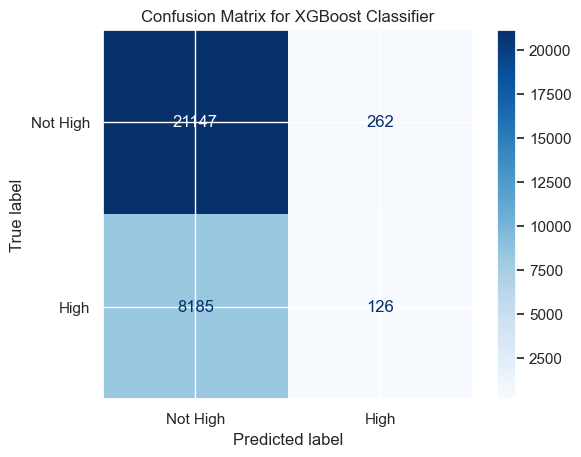

In [10]:
mode_redo_0 = True
if mode_redo_0:
    # n 100 : 14.875
    xgb_mdl = xgb.XGBClassifier(
        verbosity=0,
        objective="binary:hinge",
        random_state=42,
        n_jobs=-1,
        #use_label_encoder=False, # Recommended to avoid a future warning
        eval_metric=fun_nb_trade_fixed_window, #fun_trades_gain, #[fun_nb_trade_fixed_window, precision_score], #, # A common metric for binary classification
        max_depth=best_params_["max_depth"],
        learning_rate=best_params_["learning_rate"],
        subsample=best_params_["subsample"],
        colsample_bytree=best_params_["colsample_bytree"],
        reg_alpha=best_params_["reg_alpha"],
        reg_lambda=best_params_["reg_lambda"],
        #scale_pos_weight=1.5,  # ajuster si classes déséquilibrées
        n_estimators=5000,#400+59+1,
    )
    xgb_mdl.fit(
        df_combined_condition, 
        y_comb, 
        eval_set=[(df_combined_condition_test, y_comb_test), (df_combined_condition, y_comb)],
        verbose=0,
    )
    print("Model trained.")
    # save xgb_mdl
    with open(os.path.join(path_data,'xgb_mdl_00_PC.pkl'), 'wb') as f:
        pickle.dump(xgb_mdl, f)
else:
    # load  xgb_mdl
    xgb_mdl = pickle.load(open(os.path.join(path_data,'xgb_mdl_00_PC.pkl'), 'rb'))
    print("Model loaded.")

print("Accuracy on training data:", xgb_mdl.score(df_combined_condition, y_comb))
print("Accuracy on test data:", xgb_mdl.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = xgb_mdl.predict(df_combined_condition)
arr_xgb_pred = xgb_mdl.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [11]:
arr_eval = xgb_mdl.evals_result_["validation_0"]
arr_eval_train = xgb_mdl.evals_result_["validation_1"]
arr_eval_nb_trade, arr_eval_precision = fun_decoded_nb_trade_fixed_window(np.array(arr_eval["fun_nb_trade_fixed_window"]))
arr_eval_nb_trade_train, arr_eval_precision_train = fun_decoded_nb_trade_fixed_window(
    np.array(arr_eval_train["fun_nb_trade_fixed_window"])
)
arr_eval_gain = fun_arr_trade(arr_eval_nb_trade, arr_eval_precision, risk=250, R=1.23)
arr_eval_gain_train = fun_arr_trade(arr_eval_nb_trade_train, arr_eval_precision_train, risk=250, R=1.23)

df = pd.DataFrame({
    'trades_train': arr_eval_nb_trade_train*r_period_train,
    'precision_train': arr_eval_precision_train,
    'gain_train': arr_eval_gain_train*r_period_train,
    'trades_test': arr_eval_nb_trade*r_period_test,
    'precision_test': arr_eval_precision,
    'gain_test': arr_eval_gain*r_period_test,
})
# The index is automatically available, but we can add it as a column if we want to name it.
df['run_index'] = df.index

df

,trades_train,precision_train,gain_train,trades_test,precision_test,gain_test,run_index
0,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0
1,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,1
2,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,2
3,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,3
4,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,4
...,...,...,...,...,...,...,...
4995,48.678688,0.556499,2932.802970,36.339166,0.339844,-2199.862974,4995
4996,68.105061,0.526143,2950.632853,55.235532,0.314904,-4111.789315,4996
4997,55.572956,0.546332,3033.176956,42.153432,0.336634,-2627.277778,4997
4998,47.293391,0.557173,2867.112065,34.304172,0.329268,-2278.932164,4998


In [12]:
df[df["gain_test"] == df["gain_test"].max()]

,trades_train,precision_train,gain_train,trades_test,precision_test,gain_test,run_index
460,19.039778,0.486275,401.707188,6.97712,0.615385,649.410338,460


In [13]:
df.sort_values(by=['gain_test'], ascending=False)

,trades_train,precision_train,gain_train,trades_test,precision_test,gain_test,run_index
460,19.039778,0.486275,401.707188,6.977120,0.615385,649.410338,460
452,19.587454,0.489510,448.588434,8.430686,0.555556,503.501416,452
418,11.597834,0.499373,329.383686,4.651413,0.636364,487.342189,418
27,3.318269,0.402439,-85.081279,2.616420,0.769231,467.936976,27
311,9.632646,0.498494,268.851044,4.360700,0.640000,465.722746,311
...,...,...,...,...,...,...,...
4824,86.242785,0.483669,1694.279828,82.562584,0.290990,-7246.771888,4824
4511,86.275001,0.493677,2176.280648,83.144011,0.286859,-7489.288852,4511
4451,79.928408,0.497678,2194.473219,78.201884,0.274775,-7570.954133,4451
4521,79.928408,0.488995,1807.557977,74.422611,0.265866,-7574.711397,4521


In [14]:
def fun_arr_winrate(arr_nb_trade, gain, risk, R):
    """Mock function to simulate win rate calculation."""
    # This is a placeholder to make the example runnable.
    # The formula is derived from a common trading gain formula.
    return (gain / arr_nb_trade + risk) / (risk * (1 + R))

# --- Updated plotting function ---

def fun_plot_pre_trade(df, gain_period_min=333, gain_period_bingo=1000):

    arr_nb_trade_winrate_train = np.linspace(max(1, min(df["trades_train"])), max(df["trades_train"]), 100)
    arr_winrate_min_train = fun_arr_winrate(arr_nb_trade_winrate_train, gain=gain_period_min, risk=250, R=1.23)
    arr_winrate_bingo_train = fun_arr_winrate(arr_nb_trade_winrate_train, gain=gain_period_bingo, risk=250, R=1.23)

    # --- Create the Plot with opacity for the test data ---
    fig = px.scatter(
        df,
        x='trades_test',
        y='precision_test',
        title="Evaluation Precision vs. Number of Trades",
        color_discrete_sequence=["#3CB620"], # Green for test data
        opacity=0.6,  # Added opacity for the main scatter plot
    )
    # Customize the hover template
    fig.update_traces(
            hovertemplate="Run Index: %{customdata[0]}<br>" +
                "Gain Train: %{customdata[1]:.2f}<br>" +
                "Trades Train: %{customdata[3]:.2f}<br>" +
                "Winrate Train: %{customdata[4]:.4f}<br>" +
                "<b>Gain Test: %{customdata[2]:.2f}</b><br>" +
                "Trades Test: %{x:.2f}<br>" +
                "Winrate Test: %{y:.4f}<br>" + # Corrected from Winrate Train
                    "<extra></extra>",
            customdata=df[['run_index', 'gain_train', "gain_test", "trades_train", "precision_train"]],
            name="test" # Assign a name for the legend
    )

    # add precision = f(nb_trade) to have a gain = 333/mth
    fig.add_scatter(
        x=arr_nb_trade_winrate_train,
        y=arr_winrate_min_train,
        mode='lines',
        line=dict(color='red', width=2),
        line_dash="dash",
        name="333$/mth Precision",
        hovertemplate=f"Gain: {gain_period_min:.2f}<br>" +
                    "Number of Trades: %{x}<br>" +
                    "Precision: %{y:.4f}<br>" +
                    "<extra></extra>",
    )
    # add precision = f(nb_trade) to have a gain = 1000/mth
    fig.add_scatter(
        x=arr_nb_trade_winrate_train,
        y=arr_winrate_bingo_train,
        mode='lines',
        line=dict(color='blue', width=2),
        line_dash="dash",
        name="1000$/mth Precision",
        hovertemplate=f"Gain: {gain_period_bingo:.2f}<br>" +
                    "Number of Trades: %{x}<br>" +
                    "Precision: %{y:.4f}<br>" +
                    "<extra></extra>",
    )
    # add train data with opacity
    fig.add_trace(
        go.Scatter(
            x=df["trades_train"],
            y=df["precision_train"],
            name="train",
            mode="markers",
            # Added marker dict to set color and opacity for the train data
            marker=dict(
                color="#FF7F0E", # Orange for train data
                opacity=0.6
            ),
            hovertemplate="Run Index: %{customdata[0]}<br>" +
                "<b>Gain Train: %{customdata[1]:.2f}</b><br>" +
                "Trades Train: %{x:.2f}<br>" +
                "Winrate Train: %{y:.4f}<br>" +
                "Gain Test: %{customdata[2]:.2f}<br>" +
                "Trades Test: %{customdata[3]:.2f}<br>" +
                "Winrate Test: %{customdata[4]:.4f}<br>" +
                    "<extra></extra>",
            customdata=df[['run_index', 'gain_train', "gain_test", "trades_test", "precision_test"]],
        )
    )

    fig.update_layout(
        xaxis_title="Number of Trades / mth",
        yaxis_title="Precision",
        font=dict(family="Arial, sans-serif", size=14),
        height=600,
        legend_title_text='Data Type' # Add a title to the legend
    )

    fig.show()

fun_plot_pre_trade(df)


In [15]:
def fun_plot_xgb_rounds(df, gain_period_min=333, gain_period_bingo=1000):
    """
    Plots XGBoost model performance with semi-transparent markers.
    """
    layout = dict(
        hoversubplots="axis",
        title=dict(text="XBGBoost model performance"),
        hovermode="x",
        grid=dict(rows=3, columns=1),
        height=600,
        xaxis_title="XGB Rounds",
        yaxis=dict(
            title="Trades"
        ),
        yaxis2=dict(
            title="Precision"
        ),
        yaxis3=dict(
            title="Gain"
        )
    )

    # Define marker styles for train and test to reduce repetition
    # The 'opacity' property (from 0 to 1) controls the alpha effect.
    train_marker = dict(color="blue", opacity=0.5)
    test_marker = dict(color="red", opacity=0.5)

    data = [
        go.Scatter(x=df["run_index"], y=df["trades_train"], xaxis="x", yaxis="y", name="trades train", mode="markers", marker=train_marker),
        go.Scatter(x=df["run_index"], y=df["trades_test"], xaxis="x", yaxis="y", name="trades test",  mode="markers", marker=test_marker),
        go.Scatter(x=df["run_index"], y=df["precision_train"], xaxis="x", yaxis="y2", name="pre train",  mode="markers", marker=train_marker),
        go.Scatter(x=df["run_index"], y=df["precision_test"], xaxis="x", yaxis="y2", name="pre test",  mode="markers", marker=test_marker),
        go.Scatter(x=df["run_index"], y=df["gain_train"], xaxis="x", yaxis="y3", name="gain train",  mode="markers", marker=train_marker),
        go.Scatter(x=df["run_index"], y=df["gain_test"], xaxis="x", yaxis="y3", name="gain test",  mode="markers", marker=test_marker),
    ]

    fig = go.Figure(data=data, layout=layout)

    fig.add_hline(
        y=gain_period_min,
        xref="x",
        yref="y3",
        line_dash="dot",
        line=dict(color='red', width=2),
        annotation_text=f"Gain: {gain_period_min:.2f}$/mth",
        annotation_position="bottom right",
        annotation_font_color="red",
        annotation_font_size=8,
        row=3,
        col=1,
    )
    fig.add_hline(
        y=gain_period_bingo,
        xref="x",
        yref="y3",
        line_dash="dot",
        annotation_text=f"Gain: {gain_period_bingo:.2f}$/mth",
        annotation_position="top right",
        annotation_font_color="blue",
        annotation_font_size=8,
        row=3,
        col=1,
    )
    fig.update_xaxes(
        showspikes=True,
        spikemode='across',
        spikesnap='cursor',
        spikethickness=1,
        spikedash='dot',
    )
    fig.show()

fun_plot_xgb_rounds(df)


In [16]:
fun_plot_xgb_rounds(df[(df["gain_test"] > -10000) & (df["run_index"] < 500)])

### CV scoring precision

In [17]:
randint(1, 6).rvs(10)

array([4, 5, 3, 2, 1, 4, 3, 3, 1, 5])

In [18]:
uniform(0.4, 1-0.4).rvs(10)

array([0.42611341, 0.5233637 , 0.42838352, 0.42488273, 0.58570104,
       0.94138712, 0.8439353 , 0.43207742, 0.95542003, 0.42371089])

In [19]:
int(y_comb.shape[0]/3/3)

29798

In [20]:
29798*3*3

268182

In [21]:
y_comb.shape[0]

268188

In [22]:
(y_comb.shape[0]/3/3)/288

103.4675925925926

In [23]:
4**6

4096

In [24]:
        # resource= "n_estimators",
        # factor=3,  # Keep the top 1/3 of candidates in each iteration
        # n_candidates=2000, # 
        # min_resources=50,
        # aggressive_elimination=False,
        # max_resources=500, 
# Starting HalvingRandomSearchCV...
# n_iterations: 3
# n_required_iterations: 7
# n_possible_iterations: 3
# min_resources_: 50
# max_resources_: 500
# aggressive_elimination: False
# factor: 3
# ----------
# iter: 0
# n_candidates: 2000
# n_resources: 50
# Fitting 3 folds for each of 2000 candidates, totalling 6000 fits

In [25]:
best_params_

{'colsample_bytree': 0.41454481942774946,
 'learning_rate': 0.5958647884535192,
 'max_depth': 2,
 'reg_alpha': 0.07177580622651303,
 'reg_lambda': 0.6826172212234024,
 'subsample': 0.4177385122839766}

In [26]:
uniform(best_params_["colsample_bytree"]*0.9, best_params_["colsample_bytree"]*0.2).rvs(10)


array([0.44363737, 0.41106428, 0.44852485, 0.4166154 , 0.40473083,
       0.38039617, 0.41106188, 0.45432073, 0.41813059, 0.41133538])

In [27]:
mode_redo = True

In [28]:
# 11 iterations / 173min !  8000 resources sur trop de iteration puis division par 2 jusqu'a itera 6 ? 
# 2000 /2 , /2 /2 ... 11 fois
if mode_redo:
    # --- 3. Define the Base Model ---
    # Note: 'n_estimators' is controlled by the search, so we don't set it here.
    # 'early_stopping_rounds' is not used directly with HalvingRandomSearchCV.
    xgb_mdl = xgb.XGBClassifier(
        device='cuda',
        objective="binary:hinge",
        random_state=42,
        n_jobs=1,
        #use_label_encoder=False, # Recommended to avoid a future warning
        #eval_metric=fun_nb_trade_fixed_window, # A common metric for binary classification
        #n_estimators=100,
    )

    # --- 4. Define the Hyperparameter Search Space ---
    param_dist = {
        'max_depth': [1,2,3],             # Search depths from 1 to 6
        'learning_rate': uniform(best_params_["learning_rate"]*0.97, best_params_["learning_rate"]*0.06),   # Search from 0.05 up to 0.6
        'subsample': uniform(best_params_["subsample"]*0.97, best_params_["subsample"]*0.06),         # Search between 0.4 and 0.9
        'colsample_bytree': uniform(best_params_["colsample_bytree"]*0.97, best_params_["colsample_bytree"]*0.06),  # Search between 0.1 and 0.6
        'reg_alpha': uniform(best_params_["reg_alpha"]*0.97, best_params_["reg_alpha"]*0.06),         # Search L1 regularization
        'reg_lambda': uniform(best_params_["reg_lambda"]*0.97, best_params_["reg_lambda"]*0.06),        # Search L2 regularization
        #'scale_pos_weight': uniform(1, 3),  # ajuster si classes déséquilibrées
    }

    tscv = TimeSeriesSplit(n_splits=3, test_size=y_comb_test.shape[0])

    # --- 5. Set up and Run HalvingRandomSearchCV ---
    halving_search_2 = HalvingRandomSearchCV(
        n_jobs=1,                # Use all available CPU cores
        random_state=42,
        verbose=2,                # Set to 1 or 2 to see the progress
        cv=tscv,
        estimator=xgb_mdl,
        param_distributions=param_dist,
        resource= "n_estimators",
        factor=4,  # Keep the top 1/3 of candidates in each iteration
        n_candidates=40,
        min_resources=50,
        aggressive_elimination=False,
        max_resources=200,        # The maximum n samples to use for the final model
        scoring=make_scorer(precision_score, zero_division=0),       # Metric for evaluation, since hinge loss gives 0/1
    )

    print("Starting HalvingRandomSearchCV...")
    # Fit the model to the data
    halving_search_2.fit(df_combined_condition, y_comb)
    print("\nSearch complete!")

    # --- 6. Display the Results ---
    print("\n--- Cross-Validation Results ---")
    print(f"Best Score (Accuracy): {halving_search_2.best_score_:.4f}")
    print("\nBest Parameters Found:")
    # Using a loop for cleaner printing
    for param, value in halving_search_2.best_params_.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.4f}")
        else:
            print(f"  {param}: {value}")
    # save halving_search
    with open(os.path.join(path_data,'xgb_halving_search_06_01.pkl'), 'wb') as f:
        pickle.dump(halving_search_2, f)
else:
    # load  halving_search
    halving_search_2 = pickle.load(open(os.path.join(path_data,'xgb_halving_search_06_01.pkl'), 'rb'))
# The best_estimator_ is a fully trained model on the entire dataset
# using the best parameters found.
best_model_2 = halving_search_2.best_estimator_
print("\nBest model is now trained and ready to be used for predictions.")

Starting HalvingRandomSearchCV...
n_iterations: 2
n_required_iterations: 3
n_possible_iterations: 2
min_resources_: 50
max_resources_: 200
aggressive_elimination: False
factor: 4
----------
iter: 0
n_candidates: 40
n_resources: 50
Fitting 3 folds for each of 40 candidates, totalling 120 fits


c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\xgboost\core.py:729: UserWarning:

[23:42:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.




[CV] END colsample_bytree=0.4114242948010786, learning_rate=0.6119786755440344, max_depth=3, n_estimators=50, reg_alpha=0.0729803090488457, reg_lambda=0.6865839163649511, subsample=0.41638084756972904; total time= 1.2min
[CV] END colsample_bytree=0.4114242948010786, learning_rate=0.6119786755440344, max_depth=3, n_estimators=50, reg_alpha=0.0729803090488457, reg_lambda=0.6865839163649511, subsample=0.41638084756972904; total time= 1.2min
[CV] END colsample_bytree=0.4114242948010786, learning_rate=0.6119786755440344, max_depth=3, n_estimators=50, reg_alpha=0.0729803090488457, reg_lambda=0.6865839163649511, subsample=0.41638084756972904; total time= 1.6min
[CV] END colsample_bytree=0.4045951198504217, learning_rate=0.5944078594314389, max_depth=1, n_estimators=50, reg_alpha=0.07221126291588136, reg_lambda=0.691139256715478, subsample=0.4057222930768521; total time= 1.1min
[CV] END colsample_bytree=0.4045951198504217, learning_rate=0.5944078594314389, max_depth=1, n_estimators=50, reg_alp

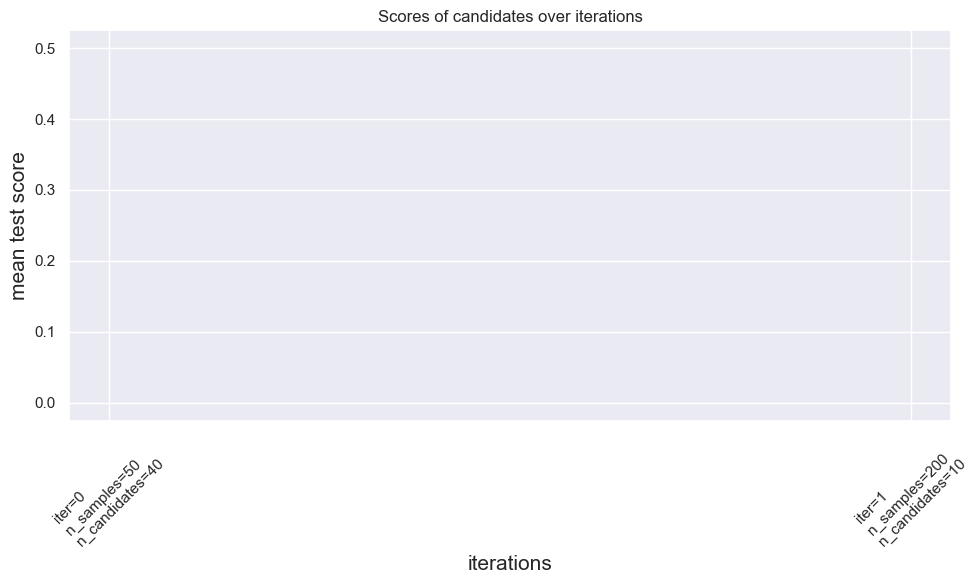

In [29]:
results = pd.DataFrame(halving_search_2.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={halving_search_2.n_resources_[i]}\nn_candidates={halving_search_2.n_candidates_[i]}"
    for i in range(halving_search_2.n_iterations_)
]

ax.set_xticks(range(halving_search_2.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.gcf().set_size_inches((10, 6))
plt.tight_layout()
plt.show()

In [30]:
mean_scores

params_str,"{'colsample_bytree': np.float64(0.40245867789881695), 'learning_rate': np.float64(0.5850978360227915), 'max_depth': 3, 'reg_alpha': np.float64(0.0730254612286435), 'reg_lambda': np.float64(0.6869570274361574), 'subsample': np.float64(0.42842344997050774), 'n_estimators': 50}","{'colsample_bytree': np.float64(0.4045006443052396), 'learning_rate': np.float64(0.6116143265617563), 'max_depth': 3, 'reg_alpha': np.float64(0.07365660504920553), 'reg_lambda': np.float64(0.6677711544718777), 'subsample': np.float64(0.4137549499201289), 'n_estimators': 200}","{'colsample_bytree': np.float64(0.4045006443052396), 'learning_rate': np.float64(0.6116143265617563), 'max_depth': 3, 'reg_alpha': np.float64(0.07365660504920553), 'reg_lambda': np.float64(0.6677711544718777), 'subsample': np.float64(0.4137549499201289), 'n_estimators': 50}","{'colsample_bytree': np.float64(0.4045951198504217), 'learning_rate': np.float64(0.5944078594314389), 'max_depth': 1, 'reg_alpha': np.float64(0.07221126291588136), 'reg_lambda': np.float64(0.691139256715478), 'subsample': np.float64(0.4057222930768521), 'n_estimators': 50}","{'colsample_bytree': np.float64(0.4049308664672676), 'learning_rate': np.float64(0.6110483868343062), 'max_depth': 2, 'reg_alpha': np.float64(0.07261896121308703), 'reg_lambda': np.float64(0.6714994354340895), 'subsample': np.float64(0.40959148157316577), 'n_estimators': 200}","{'colsample_bytree': np.float64(0.4049308664672676), 'learning_rate': np.float64(0.6110483868343062), 'max_depth': 2, 'reg_alpha': np.float64(0.07261896121308703), 'reg_lambda': np.float64(0.6714994354340895), 'subsample': np.float64(0.40959148157316577), 'n_estimators': 50}","{'colsample_bytree': np.float64(0.40629432562625006), 'learning_rate': np.float64(0.58581007852494), 'max_depth': 1, 'reg_alpha': np.float64(0.07136167204538477), 'reg_lambda': np.float64(0.6647964985107289), 'subsample': np.float64(0.4115705717512315), 'n_estimators': 200}","{'colsample_bytree': np.float64(0.40629432562625006), 'learning_rate': np.float64(0.58581007852494), 'max_depth': 1, 'reg_alpha': np.float64(0.07136167204538477), 'reg_lambda': np.float64(0.6647964985107289), 'subsample': np.float64(0.4115705717512315), 'n_estimators': 50}","{'colsample_bytree': np.float64(0.40664117641123626), 'learning_rate': np.float64(0.6049944408178064), 'max_depth': 2, 'reg_alpha': np.float64(0.07186223013047752), 'reg_lambda': np.float64(0.684530335688675), 'subsample': np.float64(0.4098396064298752), 'n_estimators': 200}","{'colsample_bytree': np.float64(0.40664117641123626), 'learning_rate': np.float64(0.6049944408178064), 'max_depth': 2, 'reg_alpha': np.float64(0.07186223013047752), 'reg_lambda': np.float64(0.684530335688675), 'subsample': np.float64(0.4098396064298752), 'n_estimators': 50}",...,"{'colsample_bytree': np.float64(0.4234581665896603), 'learning_rate': np.float64(0.5896424908454734), 'max_depth': 3, 'reg_alpha': np.float64(0.07268513190201842), 'reg_lambda': np.float64(0.6952934658683001), 'subsample': np.float64(0.4139454295643736), 'n_estimators': 50}","{'colsample_bytree': np.float64(0.4243885243260228), 'learning_rate': np.float64(0.5949842274483244), 'max_depth': 1, 'reg_alpha': np.float64(0.07181271632260892), 'reg_lambda': np.float64(0.6993099348571173), 'subsample': np.float64(0.41145469481117375), 'n_estimators': 50}","{'colsample_bytree': np.float64(0.4244579338746573), 'learning_rate': np.float64(0.5996698282006814), 'max_depth': 3, 'reg_alpha': np.float64(0.07122578578256998), 'reg_lambda': np.float64(0.7006437812708836), 'subsample': np.float64(0.4296105698733098), 'n_estimators': 50}","{'colsample_bytree': np.float64(0.4245042932998924), 'learning_rate': np.float64(0.6006234167543787), 'max_depth': 1, 'reg_alpha': np.float64(0.07082350500966456), 'reg_lambda': np.float64(0.6908232835321843), 'subsample': np.float64(0.42642733487349427), 'n_estimators': 50}","{'colsample_bytree': np.float64(0.42523255556968226), 'learning_rate': np.float64(0.6068806735407614

Model trained.
Accuracy on training data: 0.7544521007651349
Accuracy on test data: 0.7202893674293405
For Model XGBoost: 
precision TRAIN: 0.476
% possible trades : 0.20
nb trade per day : 0.58
precision TEST: 0.450
% possible trades : 0.07
nb trade per day : 0.19


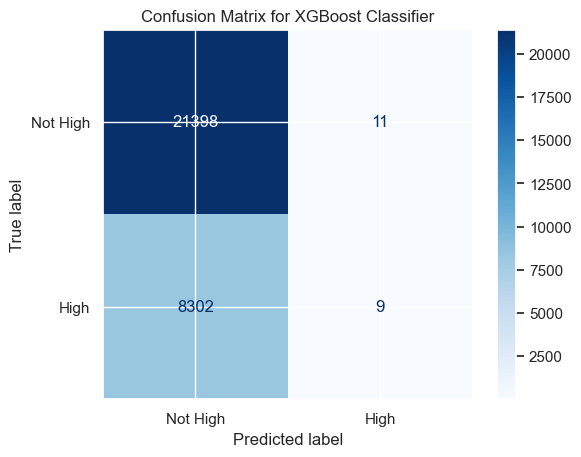

In [31]:
print("Model trained.")
print("Accuracy on training data:", best_model_2.score(df_combined_condition, y_comb))
print("Accuracy on test data:", best_model_2.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = best_model_2.predict(df_combined_condition)
arr_xgb_pred = best_model_2.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [32]:
halving_search_2.best_params_

{'colsample_bytree': np.float64(0.4091703529971746),
 'learning_rate': np.float64(0.5889061791226413),
 'max_depth': 2,
 'reg_alpha': np.float64(0.07260221217803638),
 'reg_lambda': np.float64(0.6888411035851189),
 'subsample': np.float64(0.41082751257655786),
 'n_estimators': 200}

In [33]:
results.columns

Index(['iter', 'n_resources', 'mean_fit_time', 'std_fit_time',
       'mean_score_time', 'std_score_time', 'param_colsample_bytree',
       'param_learning_rate', 'param_max_depth', 'param_reg_alpha',
       'param_reg_lambda', 'param_subsample', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'mean_train_score', 'std_train_score', 'params_str'],
      dtype='object')

In [34]:
results[results["rank_test_score"] == 1].iloc[0]["param_n_estimators"]

np.int64(50)

In [35]:
results[results["rank_test_score"] == 1].iloc[0]["param_learning_rate"]

np.float64(0.58581007852494)

In [36]:
results.filter(items=['param_learning_rate', 'param_max_depth', 'param_reg_alpha',
       'param_reg_lambda', 'param_subsample', 
       'param_n_estimators', 'mean_test_score', "mean_train_score", "rank_test_score"]
).sort_values(by="mean_test_score", ascending=False).head(10)

,param_learning_rate,param_max_depth,param_reg_alpha,param_reg_lambda,param_subsample,param_n_estimators,mean_test_score,mean_train_score,rank_test_score
24,0.585810,1,0.071362,0.664796,0.411571,50,0.500000,0.288515,1
28,0.586485,3,0.073081,0.681401,0.429855,50,0.386554,0.542078,2
46,0.588906,2,0.072602,0.688841,0.410828,200,0.382112,0.500674,3
41,0.611614,3,0.073657,0.667771,0.413755,200,0.372625,0.588820,4
42,0.589642,3,0.072685,0.695293,0.413945,200,0.372518,0.595478,5
32,0.611048,2,0.072619,0.671499,0.409591,50,0.372413,0.440223,6
37,0.588906,2,0.072602,0.688841,0.410828,50,0.372222,0.434227,7
48,0.586485,3,0.073081,0.681401,0.429855,200,0.372132,0.601936,8
8,0.604994,2,0.071862,0.684530,0.409840,50,0.370411,0.464738,9
43,0.612729,3,0.072899,0.685127,0.424530,200,0.359453,0.638482,10


### Long train


In [37]:
mode_redo = True


In [38]:
# from CV : objective="binary:hinge", scoring="precision", min_resources=500,
# Best Score (Accuracy): 0.3451
#   colsample_bytree: 0.4145
#   learning_rate: 0.5959
#   max_depth: 2
#   reg_alpha: 0.0718
#   reg_lambda: 0.6826
#   subsample: 0.4177

In [39]:
params_ = best_model_2.get_params()
params_

{'objective': 'binary:hinge',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': np.float64(0.4091703529971746),
 'device': 'cuda',
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': np.float64(0.5889061791226413),
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 2,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 200,
 'n_jobs': 1,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': np.float64(0.07260221217803638),
 'reg_lambda': np.float64(0.6888411035851189),
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': np.float64(0.410827

[0]	validation_0-error:0.27964	validation_0-fun_nb_trade_fixed_window:0.00000	validation_1-error:0.24545	validation_1-fun_nb_trade_fixed_window:0.00000
[100]	validation_0-error:0.28139	validation_0-fun_nb_trade_fixed_window:580.30000	validation_1-error:0.24713	validation_1-fun_nb_trade_fixed_window:6260.34943
[200]	validation_0-error:0.28062	validation_0-fun_nb_trade_fixed_window:440.30667	validation_1-error:0.24607	validation_1-fun_nb_trade_fixed_window:5780.42757
[300]	validation_0-error:0.28126	validation_0-fun_nb_trade_fixed_window:880.35882	validation_1-error:0.24696	validation_1-fun_nb_trade_fixed_window:11630.41835
[400]	validation_0-error:0.28015	validation_0-fun_nb_trade_fixed_window:300.34694	validation_1-error:0.24558	validation_1-fun_nb_trade_fixed_window:3870.47703
[500]	validation_0-error:0.28176	validation_0-fun_nb_trade_fixed_window:1030.33679	validation_1-error:0.24673	validation_1-fun_nb_trade_fixed_window:12190.43076
[600]	validation_0-error:0.28143	validation_0-fun_

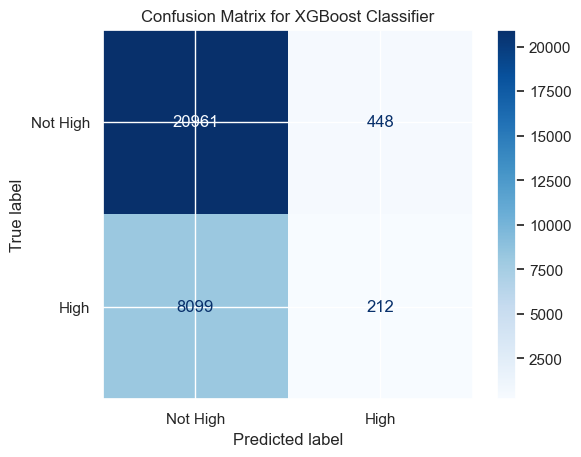

In [40]:
# params_={'colsample_bytree': np.float64(0.5109596523594455), 
#          'learning_rate': np.float64(0.47114238729749924), 
#          'max_depth': 4, 
#          'reg_alpha': np.float64(1.8789978831283782), 
#          'reg_lambda': np.float64(3.5793094017105953), 
#          'subsample': np.float64(0.7092649925838798), 
#          'n_estimators': 200
# }
if mode_redo:
    # n 100 : 14.875
    xgb_mdl = xgb.XGBClassifier(
        device='cuda',
        verbosity=0,
        objective="binary:hinge",
        random_state=42,
        n_jobs=-1,
        #use_label_encoder=False, # Recommended to avoid a future warning
        eval_metric=fun_nb_trade_fixed_window, #fun_trades_gain, #[fun_nb_trade_fixed_window, precision_score], #, # A common metric for binary classification
        max_depth=params_['max_depth'],
        learning_rate=params_['learning_rate'],
        subsample=params_['subsample'],
        colsample_bytree=params_['colsample_bytree'],
        reg_alpha=params_['reg_alpha'],
        reg_lambda=params_['reg_lambda'],
        #scale_pos_weight=1.5,  # ajuster si classes déséquilibrées
        n_estimators=10000,#400+59+1,
    )
    xgb_mdl.fit(
        df_combined_condition, 
        y_comb, 
        eval_set=[(df_combined_condition_test, y_comb_test), (df_combined_condition, y_comb)],
        verbose=100,
    )
    print("Model trained.")
    # save xgb_mdl
    with open(os.path.join(path_data,'xgb_mdl_06_01.pkl'), 'wb') as f:
        pickle.dump(xgb_mdl, f)
else:
    # load  xgb_mdl
    xgb_mdl = pickle.load(open(os.path.join(path_data,'xgb_mdl_06_01.pkl'), 'rb'))
    print("Model loaded.")

print("Accuracy on training data:", xgb_mdl.score(df_combined_condition, y_comb))
print("Accuracy on test data:", xgb_mdl.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = xgb_mdl.predict(df_combined_condition)
arr_xgb_pred = xgb_mdl.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [41]:
arr_eval = xgb_mdl.evals_result_["validation_0"]
arr_eval_train = xgb_mdl.evals_result_["validation_1"]
arr_eval_nb_trade, arr_eval_precision = fun_decoded_nb_trade_fixed_window(np.array(arr_eval["fun_nb_trade_fixed_window"]))
arr_eval_nb_trade_train, arr_eval_precision_train = fun_decoded_nb_trade_fixed_window(
    np.array(arr_eval_train["fun_nb_trade_fixed_window"])
)
arr_eval_gain = fun_arr_trade(arr_eval_nb_trade, arr_eval_precision, risk=250, R=1.23)
arr_eval_gain_train = fun_arr_trade(arr_eval_nb_trade_train, arr_eval_precision_train, risk=250, R=1.23)

df = pd.DataFrame({
    'trades_train': arr_eval_nb_trade_train*r_period_train,
    'precision_train': arr_eval_precision_train,
    'gain_train': arr_eval_gain_train*r_period_train,
    'trades_test': arr_eval_nb_trade*r_period_test,
    'precision_test': arr_eval_precision,
    'gain_test': arr_eval_gain*r_period_test,
})
# The index is automatically available, but we can add it as a column if we want to name it.
df['run_index'] = df.index

df

,trades_train,precision_train,gain_train,trades_test,precision_test,gain_test,run_index
0,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0
1,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,1
2,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,2
3,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,3
4,0.096649,0.333333,-6.201638,0.000000,0.000000,-0.000000,4
...,...,...,...,...,...,...,...
9995,63.755873,0.583223,4791.051253,49.130552,0.352025,-2640.573709,9995
9996,54.026578,0.615489,5031.771725,38.955585,0.361789,-1881.657329,9996
9997,75.965815,0.564740,4925.817159,63.084791,0.340858,-3783.299976,9997
9998,61.178576,0.585535,4676.231122,47.386272,0.341772,-2817.687710,9998


In [42]:
fun_plot_pre_trade(df)

In [43]:
fun_plot_xgb_rounds(df)